# Chapter 4: Chemical Reactions
The simulation procedure described in the previous chapter is now applied to a series of simple examples that represent chemical reactions. We first remind the reader of some key properties of chemical reactions that will show up in dynamic simulations and determine characteristics of network dynamic responses. We then go through a set of examples of chemical reactions that occur in a _closed system_. A closed system is isolated from its environment. No molecules enter or leave the system. Reactions being carried out in the laboratory in a sealed container represent an example of closed systems. In this chapter we assign numerical values to all the parameters for illustration purposes. We start by importing **MASSpy**:

In [1]:
from mass import (
    MassModel, MassMetabolite, MassReaction, Simulation)
from mass.visualization import plot_time_profile, plot_phase_portrait

Other useful packages are also imported at this time.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## 4.1 Basic Properties of Reactions
Links between molecular components in a biochemical reaction network are given by chemical reactions or associations between chemical components. These links are therefore characterized and constrained by basic chemical rules.

### Bi-linear reactions are prevalent in biology
Although there are linear reactions found in biological reaction networks, the prototypical transformations in living systems at the molecular level are bi-linear. This association involves two compounds coming together to either be chemically transformed through the breakage and formation of a new covalent bond, as is typical of metabolic reactions or macromolecular synthesis, 

$$\begin{equation*} \text{X} +\text{Y} \rightleftharpoons \text{X-Y}\ \text{covalent bonds} \end{equation*}$$

or two molecules associated together to form a complex that may be held together by hydrogen bonds and/or other physical association forces to form a complex that has a different functionality than individual components, 

$$\begin{equation*}\text{X} +\text{Y} \rightleftharpoons \text{X:Y}\ \text{association of molecules} \end{equation*}$$

Such association, for instance, could designate the binding of a transcription factor to DNA to form an activated site to which an activated polymerase binds. Such bi-linear association between two molecules might also involve the binding of an allosteric regulator to an allosteric enzyme that induces a conformational change in the enzyme. 

### Properties of biochemical reactions  
Chemical transformations have three key properties that will influence the dynamic features of reaction networks and how we interpret dynamic states: 

#### 1. Stoichiometry
The stoichiometry of chemical reactions is fixed and is described by integral numbers counting the molecules that react and that form as a consequence of the chemical reaction. Thus, stoichiometry basically represents "digital information." Chemical transformations are constrained by elemental and charge balancing, as well as other features. Stoichiometry is invariant between organisms for the same reactions and does not change with pressure, temperature, or other conditions. Stoichiometry gives the primary topological properties of a biochemical reaction network. 

#### 2. Thermodynamics
All reactions inside a cell are governed by thermodynamics that determine the equilibrium state of a reaction. The relative rates of the forward and reverse reactions are therefore fixed by basic thermodynamic properties. Unlike stoichiometry, thermodynamic properties do change with physico-chemical conditions such as pressure and temperature. Thus the thermodynamics of transformation between small molecules in cells are fixed but condition-dependent. The thermodynamic properties of associations between macromolecules can be changed by altering the amino acid sequence of a protein or by phosphorylation of amino acids in the interface region, or by conformational change induced by the binding of a small molecule ligand. 

#### 3. Absolute Rates
In contrast to stoichiometry and thermodynamics, the absolute rates of chemical reactions inside cells are highly manipulable. Highly evolved enzymes are very specific in catalyzing particular chemical transformations. Cells can thus extensively manipulate the absolute rates of reactions through changes in their DNA sequence. 

All biochemical transformations are subject to the basic rules of chemistry and thermodynamics. 

## 4.2 The Reversible Linear Reaction
We start with the reversible linear reaction:

$$\begin{equation} x_1 \underset{v_{-1}}{\stackrel{v_1}{\rightleftharpoons}} x_2 \tag{4.1} \end{equation}$$ 

Here we have that

$$\begin{equation*} \textbf{S} = \begin{pmatrix} {-1} & {1} \\ {1}  & {-1} \\ \end{pmatrix}, \textbf{v}(\textbf{x}) = \begin{pmatrix} {v_1(x_1)} \\ {v_{-1}(x_2)} \end{pmatrix} = \begin{pmatrix} {k_1x_1} \\ {k_{-1}x_2} \end{pmatrix} \end{equation*}$$

and thus the differential equations that we will need to simulate are: 

$$\begin{equation} \frac{dx_1}{dt} = -k_1x_1 + k_{-1}x_2, \frac{dx_2}{dt} = k_1x_1 - k_{-1}x_2 = -\frac{dx_1}{dt} \tag{4.2} \end{equation}$$ 

with the reaction rate given as the difference between two elementary reaction rates 

$$\begin{equation} v_{1, net} = v_1 - v_{-1} = k_1x_1 - k_{-1}x_2 = k_1(x_1 - x_2/K_1) \tag{4.3} \end{equation}$$

where \\(K_1 = k_1/k_{-1} = x_{2, eq}/x_{1, eq}\\) or the ratio of the product to reactant concentrations at equilibrium, the conventional definition of an equilibrium constant in chemistry. Note that in Eq. (4.3), \\(k_1\\) represents the kinetics, or the rate of change, while \\((x_1 - x_2/K_1)\\) represents the thermodynamics measuring how far from equilibrium the system is, i.e.,\\((x_{1, eq} - x_{2, eq}/K_1) = 0\\). 

Below, a sample solution is shown for \\(k_1 = 1\\) and \\(k_{-1} = 2\\). These simulation results can be examined further, and they reveal three important observations; 1) the existence of a conservation quantity, 2) a thermodynamic driving force, and 3) the pooling of variables based on chemistry and thermodynamics. 

##### Create MassModel

In [3]:
# Create MassModel
model = MassModel('Linear_Reversible')
# Generate the MassMetabolites 
x1 = MassMetabolite("x1")
x2 = MassMetabolite("x2")
# Generate the MassReactions 
v1 = MassReaction("v1")
# Add metabolites to the reaction, add reaction to the model
v1.add_metabolites({x1: -1, x2: 1})
model.add_reactions([v1])
# Set parameters and initial conditions
v1.kf = 1
v1.kr = 2
model.update_initial_conditions({x1: 1, x2: 0})
# Utilize type 2 rate law for kf and kr parameters defined
model.get_rate_expressions(rate_type=2, update_reactions=True)
model

Academic license - for non-commercial use only


Name,Linear_Reversible
Memory address,0x012b848f60
Stoichiometric Matrix,2x1
Matrix Rank,1
Number of metabolites,2
Initial conditions defined,2/2
Number of reactions,1
Number of genes,0
Number of enzyme modules,0
Number of groups,0
Objective expression,0


##### Simulate MassModel

In [4]:
t0 = 0
tf = 2
sim = Simulation(model, verbose=True, variable_step_size=True)
conc_sol, flux_sol = sim.simulate(model, time=(t0, tf), verbose=True)

# Define pools
pools = ["x1 - x2 / Keq_v1", "x1 + x2"]

for i, equation_str in enumerate(pools):
    pool_id = "p" + str(i + 1)
    conc_sol.make_solution_from_equation(
        pool_id, equation=equation_str, 
        parameters={v1.Keq_str: v1.kf/v1.kr}, update=True)

Successfully loaded MassModel 'Linear_Reversible' into RoadRunner.
Getting time points
Setting output selections
Setting simulation values for 'Linear_Reversible'
Simulating 'Linear_Reversible'
Simulation for 'Linear_Reversible' successful
Adding 'Linear_Reversible' simulation solutions to output
Updating stored solutions


##### Visualize Solutions

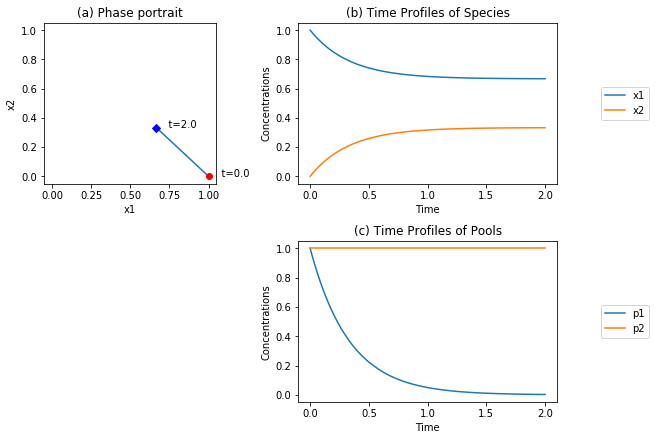

In [5]:
fig_4_1 = plt.figure(constrained_layout=True, figsize=(9, 6))
gs = fig_4_1.add_gridspec(nrows=2, ncols=2, width_ratios=[1, 1.5],
                          height_ratios=[1, 1])

ax1 = fig_4_1.add_subplot(gs[0, 0])
ax2 = fig_4_1.add_subplot(gs[0, 1])
ax3 = fig_4_1.add_subplot(gs[1, 1])

plot_phase_portrait(
    conc_sol, x=x1, y=x2, ax=ax1,
    xlabel=x1.id, ylabel=x2.id,
    xlim=(-0.05, 1.05), ylim=(-0.05, 1.05),
    title=("(a) Phase portrait", {"size":"large"}),
    annotate_time_points="endpoints",
    annotate_time_points_labels=True);

plot_time_profile(
    conc_sol, ax=ax2, observable=model.metabolites, legend="right outside",
    xlabel="Time", ylabel="Concentrations",
    title=("(b) Time Profiles of Species", {"size": "large"}));

plot_time_profile(
    conc_sol, ax=ax3, observable=["p1", "p2"],
    legend="right outside",
    xlabel="Time", ylabel="Concentrations",
    title=("(c) Time Profiles of Pools", {"size": "large"}));

*__Figure 4.1:__ Dynamic simulation of the reaction \\(x_1 \underset{v_{-1}}{\stackrel{v_1}{\rightleftharpoons}} x_2\\) for \\(k_1 =1\\) and \\(k_{-1} = 2\\), and \\(x_1(0)=1\\), \\(x_2(0)=0\\). (a) The phase portrait. (b) The time profiles. (c) The time profile of the pooled variables \\(p_1 = x_1 - x_2/K_1\\) and \\(p_1 = x_1 + x_2\\).*

#### 1) Mass conservation:  
The time profiles in Figure 4.1b show \\(x_1\\) fall and \\(x_2\\) rise to their equilibrium values. The phase portrait (Figure 4.1a) is a straight line of slope -1. This implies that

$$\begin{equation} p_1 = x_1 + x_2 = \big \langle (1, 1), (x_1, x_2)^T \big \rangle \tag{4.4} \end{equation}$$

is a constant. This summation represents a conservation quantity that stems from the fact that as \\(x_1\\) reacts, \\(x_2\\) appears in an equal and opposite amount. The stoichiometric matrix is singular with a rank of 1, showing that this is a one-dimensional dynamic system. It has a left null space that is spanned by the vector \\((1, 1), i.e., (1, 1) \centerdot \textbf{S} = 0\\), thus \\(p_2\\) is in the left null space of \\(\textbf{S}\\). 

We also note that since \\(x_1 + x_2\\) is a constant, we can describe the concentration of \\(x_1\\) as a fraction of the total mass, i.e., 

$$\begin{equation*} f_1 = \frac{x_1}{x_1 + x_2} = \frac{x_1}{p_2} \end{equation*}$$

Pool sizes and the fraction of molecules in a particular state will be used later in the text to define physiologically useful quantities. 

#### 2) Disequilibrium and the thermodynamic driving force:
A pooled variable: 

$$\begin{equation} p_1 = x_1 - x_2/K_1 \tag{4.5} \end{equation}$$

can be formed (see Figure 4.1c). Combination of the differential equations for \\(x_1\\) and \\(x_2\\) leads to 

$$\begin{equation} \frac{dp_1}{dt} = -(k_1 + k_{-1}) p_1 \tag{4.6} \end{equation}$$

and thus the time constant for this reaction is 

$$\begin{equation} \tau_{1} = \frac{1}{k_1 + k_{-1}} \tag{4.7} \end{equation}$$

Note that when \\(t \rightarrow \infty, p_1 \rightarrow 0\\) and then

$$\begin{equation} \frac{x_2}{x_1} \rightarrow \frac{k_1}{k_{-1}} = K_1 = \frac{x_{2,eq}}{x_{1, eq}} \tag{4.8} \end{equation}$$

the reaction has reached equilibrium. The pool \\(p_1\\) thus represents a disequilibrium quantity  and represents the thermodynamic driver for the reaction, see Eq. (4.3). With an initial condition of \\(x_{1, 0} = 1\\) and \\(K_1 = 1/2\\), the eventual concentrations \\((t \rightarrow \infty)\\) will be \\(x_{1, eq} = 2/3\\) and \\(x_{2, eq} = 1/3\\). 

#### 3) Representing dynamics with pools:  
These considerations show that we can think about the dynamics of reaction (4.1) in terms of two pooled variables rather than the concentrations themselves. Thus, a useful pool transforming matrix for this reaction would be 

$$\begin{equation} \textbf{P} = \begin{pmatrix} {1} & {-1/K_1} \\ {1}  & {1} \\ \end{pmatrix}  \tag{4.9} \end{equation}$$

leading to disequilibrium \\((p_1)\\) and conservation \\((p_2)\\) quantities associated with the reaction in Eq. (4.1). The former quantity moves on the time scale given by \\(\tau_1\\) while the latter is time invariant. For practical purposes, the dynamics of the reaction have relaxed within a time duration of three to five times  \\(\tau_1\\) (see Figure 4.1b). 

The differential equations for the pools can be obtained as 

$$\begin{equation} \textbf{P} \frac{d\textbf{x}}{dt} = \frac{d}{dt}\begin{pmatrix} {p_1} \\ {p_2} \\ \end{pmatrix} = -(k_1 + k_{-1})\begin{pmatrix} {x_1 - x_2/K_1} \\ {0} \\ \end{pmatrix} = -(k_1 + k_{-1})\begin{pmatrix} {p_1} \\ {0} \\ \end{pmatrix} \end{equation}$$

Therefore, the conservation quantity is a constant (time derivative is zero) and the disequilibrium pool is driven by a thermodynamic driving force that is itself multiplied by \\(-(k_1 + k_{-1})\\), that is the inverse of the time constant for the reaction. Thus, the three key features of chemical reactions, the stoichiometry, thermodynamics, and kinetics, are separately accounted for. 

## 4.3 The Reversible Bi-Linear Reaction
The reaction mechanism for the reversible bi-linear reaction is: 

$$\begin{equation} x_1 + x_2 \underset{v_{-1}}{\stackrel{v_1}{\rightleftharpoons}} x_3 \tag{4.10} \end{equation}$$ 

where the elementary reaction rates are 

$$\begin{equation} v_1 = k_1x_1x_2, \ v_{-1} = k_{-1}x_3 \tag{4.11} \end{equation}$$

The forward rate, \\(v_1\\), is a non-linear function, or more specifically, a bi-linear function. The variable 

$$\begin{equation} p_1 = x_1x_2 - x_3/K_1 \tag{4.12} \end{equation}$$

represents a disequilibrium quantity. The dynamic states of this system can be computed from 

$$\begin{equation} \frac{dx_1}{dt} = -v_1 + v_{-1} = -k_1x_1x_2 + k_{-1}x_3 = -k_1(x_1x_2 - x_3/K_1) = \frac{dx_2}{dt} = -\frac{dx_3}{dt} \tag{4.13} \end{equation}$$

This example will be used to illustrate the essential features of a bi-linear reaction; 1) That there are two conservation quantities associated with it, 2) How to compute the equilibrium state, 3) The use of linearization and deviation variables from the equilibrium state, 4) The derivation of a single linear disequilibrium quantity, and 5) Formation of pools.

#### 1) Conservation quantities
The stoichiometric matrix is 

$$\begin{equation} S = \begin{pmatrix} {-1} & {1} \\ {-1} & {1} \\ {1}  & {-1} \\ \end{pmatrix} \end{equation}$$

The stoichiometric matrix has a rank of 1, and thus the dynamic dimension of this system is 1. Two vectors that span the left null space of __S__ are (1,0,1) and (0,1,1) and the corresponding conservation quantities are: 

$$\begin{equation} p_2 = x_1 + x_3, \ p_3 = x_2 + x_3 \tag{4.14} \end{equation}$$

This selection of conservation quantities is not unique, as one can find other sets of two vectors that span the left null space. 

#### 2) The equilibrium state
We can examine the equilibrium state for the specific parameter values to be used for numerical simulation below, Figure 4.2. At equilibrium, \\(p_1 \rightarrow 0\\) and we have that \\((K_1 = 1)\\)

$$\begin{equation} x_{1, eq}x_{2, eq} = x_{3, eq} \tag{4.15} \end{equation}$$

and that 

$$\begin{equation} x_1(0) = 3 =  x_{1, eq} + x_{3, eq}, \ \ \  x_2(0) = 2 =  x_{2, eq} + x_{3, eq} \tag{4.16} \end{equation}$$

These three equations can be combined to give a second order algebraic equation 

$$\begin{equation} x_{3, eq}^2 - 6x_{3, eq} + 6 = 0  \tag{4.17} \end{equation}$$

that has a positive root that yields 

$$\begin{equation} x_{1, eq} = 1.73,\ \  x_{2, eq} = 0.73, \ \ x_{3, eq} = 1.27 \tag{4.18} \end{equation}$$

#### 3) Linearization and deviation variables
Equation (13) can be linearized around the equilibrium point \\(\textbf{x}_{eq}\\)==(1.73,0.73,1.27) to give 

$$\begin{equation} \frac{dx_1}{dt} = x_1x_2 - x_3  \tag{4.19} \end{equation}$$
$$\begin{equation} \rightarrow \frac{dx_1}{dt} = 0.73(x_1 -1.73) + 1.73(x_2 - 0.73) - (x_3 - 1.27) \tag{4.20} \end{equation}$$

where a numerical value of \\(k_1\\) used is unity. 

#### 4) The disequilibrium and conservation quantities
Equation (20) can be written in terms of deviation variables from the equilibrium state, i.e., 

$$\begin{equation} x_i' x_i - x_{i, eq} \tag{4.21} \end{equation}$$

as

$$\begin{equation} \frac{dx_1'}{dt} = 0.73x_1' + 1.73x_2' - x_3' = p_1' \tag{4.22} \end{equation}$$

which simply is the linearized version of the disequilibrium quantity in Eq.(4.12), and we have that 

$$\begin{equation} \frac{dx_2'}{dt} =\frac{dx_1'}{dt} \ \ and \ \ \frac{dx_3'}{dt} = -\frac{dx_1'}{dt} \tag{4.23} \end{equation}$$

#### 5) Representing dynamics with pools: 
We can therefore form a pool transformation matrix as: 

$$\begin{equation} \textbf{P} = \begin{pmatrix} {0.73} & {1.73} & {-1} \\ {1} & {0} & {1}  \\ {0} & {1} & {1} \\ \end{pmatrix} \tag{4.24} \end{equation}$$

where the first pool represents the disequilibrium quantity and the second and third are conservation quantities. Now we transform the deviation variables with this matrix, i.e., $\textbf{p'} = \textbf{Px'}$ and can look at the time derivatives of the pools 

$$\begin{align} \frac{d\textbf{p'}}{dt} &= \textbf{P}\frac{d\textbf{x'}}{dt} \\ &= \begin{pmatrix} {-3.46} & {3.46} \\ {0} & {0} \\ {0} & {0} \\ \end{pmatrix}(0.73x_1' + 1.73x_2' - x_3') \\ &= 3.46\begin{pmatrix} {1} \\ {0} \\ {0} \\ \end{pmatrix} p_1' \end{align} \tag{4.25}$$

This result is similar to that obtained above for the linear reversible reaction. There are two conservation pools and a disequilibrium pool that is moved by itself multiplied by a characteristic rate constant. We note that the conservation quantities, for both the linear and bi-linear reaction, do not change if the reactions are irreversible (i.e., if \\(K_{eq} \rightarrow \infty\\)) 

#### Numerical simulation
The dynamic response of this reaction can readily be computed and the results graphed; see Figure 4.2.

##### Create MassModel

In [6]:
# Create MassModel
model = MassModel('BiLinear_Reversible')
# Generate the MassMetabolites 
x1 = MassMetabolite("x1")
x2 = MassMetabolite("x2")
x3 = MassMetabolite("x3")
# Generate the MassReactions 
v1 = MassReaction("v1")
# Add metabolites to the reaction, add reaction to the model
v1.add_metabolites({x1: -1, x2: -1, x3: 1})
model.add_reactions([v1])
# Set parameters and initial conditions
v1.kf = 1
v1.kr = 1
model.update_initial_conditions({x1: 3, x2: 2, x3: 0})
# Utilize type 2 rate law for kf and kr parameters defined
model.get_rate_expressions(rate_type=2, update_reactions=True)
model

Name,BiLinear_Reversible
Memory address,0x012fb76d30
Stoichiometric Matrix,3x1
Matrix Rank,1
Number of metabolites,3
Initial conditions defined,3/3
Number of reactions,1
Number of genes,0
Number of enzyme modules,0
Number of groups,0
Objective expression,0


##### Simulate MassModel

In [7]:
t0 = 0
tf = 5
sim = Simulation(model, verbose=True, variable_step_size=True)
conc_sol, flux_sol = sim.simulate(model, time=(t0, tf), verbose=True)

# Define pools
pools = ['x1*x2 - x3 / Keq_v1', 'x1 + x3', 'x2 + x3']

for i, equation_str in enumerate(pools):
    pool_id = "p" + str(i + 1)
    conc_sol.make_solution_from_equation(
        pool_id, equation=equation_str, 
        parameters={v1.Keq_str: v1.kf/v1.kr}, update=True)

Successfully loaded MassModel 'BiLinear_Reversible' into RoadRunner.
Getting time points
Setting output selections
Setting simulation values for 'BiLinear_Reversible'
Simulating 'BiLinear_Reversible'
Simulation for 'BiLinear_Reversible' successful
Adding 'BiLinear_Reversible' simulation solutions to output
Updating stored solutions


##### Visualize Solutions

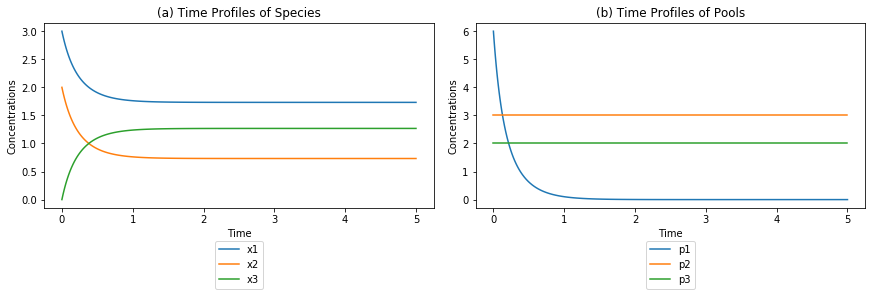

In [8]:
fig_4_2 = plt.figure(constrained_layout=True, figsize=(12, 4))
gs = fig_4_2.add_gridspec(nrows=1, ncols=2)

ax1 = fig_4_2.add_subplot(gs[0, 0])
ax2 = fig_4_2.add_subplot(gs[0, 1])

plot_time_profile(
    conc_sol, ax=ax1, observable=model.metabolites,
    legend="lower outside",
    xlabel="Time", ylabel="Concentrations",
    title=("(a) Time Profiles of Species", {"size": "large"}));

plot_time_profile(
    conc_sol, ax=ax2, observable=["p1", "p2", "p3"],
    legend="lower outside",
    xlabel="Time", ylabel="Concentrations",
    title=("(b) Time Profiles of Pools", {"size": "large"}));

*__Figure 4.2:__ The concentration time profiles for the reaction \\(x_1 + x_2 {\rightleftharpoons} x_3\\) for \\(k_1\\) = \\(k_{-1} = 1\\) and \\(x_1(0)=3\\), \\(x_2(0)=2\\), and \\(x_3(0)=0\\). (a) The concentrations as a function of time. (b) The pools as a function of time.*

## 4.4 Connected Reversible Linear Reactions
Now we consider more than one reaction working simultaneously. We will consider two reversible first order reactions that are connected by an irreversible reaction; 

$$\begin{equation} x_1 \underset{v_{-1}}{\stackrel{v_1}{\rightleftharpoons}} x_2 \stackrel{v_2} \rightarrow x_3 \underset{v_{-3}}{\stackrel{v_3}{\rightleftharpoons}} x_4 \tag{4.26} \end{equation}$$ 

The stoichiometric matrix and the reaction vector, are 

$$\begin{equation} \textbf{S} = \begin{pmatrix} {-1} & {1} & {0} & {0} & {0}  \\ {1} & {-1} & {-1} & {0} & {0}  \\ {0} & {0} & {1} & {-1} & {1}  \\  {0} & {0} & {0} & {1} & {-1}  \\ \end{pmatrix}, \  \textbf{v}(\textbf{x})  = \begin{pmatrix}  {k_1x_1} \\  {k_{-1}x_2} \\ {k_2x_2} \\ {k_3x_3} \\ {k_{-3}x_4} \\\end{pmatrix} \tag{4.27} \end{equation}$$ 
               
and thus the dynamic mass balances are; 

$$\begin{align} \frac{dx_1}{dt} &= -k_1x_1 + k_{-1}x_2 \\ \frac{dx_2}{dt} &=  k_1x_1 - k_{-1}x_2 - k_2x_2 \\ \frac{dx_3}{dt} &=  k_2x_2 - k_3x_3 + k_{-3}x_4 \\ \frac{dx_4}{dt} &=  k_3x_3 - k_{-3}x_4 \\ \end {align} \tag{4.28}$$

The net reaction rates are: 

$$\begin{equation} v_{1, net} = k_1x_1 - k_{-1}x_2 = k_1(x_1 - x_2/K_1)  \tag{4.29} \end{equation}$$  

and

$$\begin{equation} v_{3, net} = k_3x_3 - k_{-3}x_4 = k_3(x_3 - x_4/K_3) \tag{4.30} \end{equation}$$ 

where \\(K_1 = k_1/k_{-1}\\) and  \\(K_3 = k_3/k_{-3}\\) are the equilibrium constants. This example can be used to illustrate three concepts: 1) dynamic decoupling, 2) stoichiometric decoupling, and 3) formation of multi-reaction pools. 

#### 1) Dynamic decoupling through seperated time scales:
This linear system can be described by 

$$\begin{equation} \frac{d\textbf{x}}{dt} = \textbf{Jx} \tag{4.31} \end{equation}$$

where the Jacobian matrix for this system is obtained directly from the equations in (4.28): 

$$\begin{equation} \textbf{J} = \begin{pmatrix} {-k_1} & {k_{-1}} & {0} & {0} \\ {k_1} & {-k_{-1} - k_2} & {0} & {0} \\ {0} & {k_2} & {-k_3} & {-k_{-3}} \\ {0} & {0} & {k_3} & {k_{-3}} \\ \end{pmatrix} \tag{4.32} \end{equation}$$

Note that for linear systems, \\(\textbf{x} = \textbf{x'}\\). Observe that the second column in \\(\textbf{J}\\) is a combination of the second and third column in \\(\textbf{S}\\); 

$$\begin{equation} \begin{pmatrix} {j_{12}} \\ {j_{22}} \\ {j_{32}} \\ {j_{42}} \end{pmatrix} = \begin{pmatrix} {1} \\ {-1} \\ {0} \\ {0} \end{pmatrix} + \begin{pmatrix} {0} \\ {-1} \\ {1} \\ {0} \end{pmatrix} k_2 = k_{-1}\textbf{s}_2 + k_2\textbf{s}_3 \tag{4.33} \end{equation}$$

##### Create MassModel

In [9]:
# Create MassModel
model = MassModel('Connected_Linear_Reversible')
# Generate the MassMetabolites 
x1 = MassMetabolite("x1")
x2 = MassMetabolite("x2")
x3 = MassMetabolite("x3")
x4 = MassMetabolite("x4")
# Generate the MassReactions 
v1 = MassReaction("v1")
v2 = MassReaction("v2", reversible=False)
v3 = MassReaction("v3")
# Add metabolites to the reaction, add reaction to the model
v1.add_metabolites({x1: -1, x2: 1})
v2.add_metabolites({x2: -1, x3: 1})
v3.add_metabolites({x3: -1, x4: 1})
model.add_reactions([v1, v2, v3])
# Set parameters and initial conditions
v1.kf = 1
v1.Keq = 1
v2.kf = 1
v3.kf = 1
v3.Keq = 1
model.update_initial_conditions({x1: 1, x2: 0, x3: 0, x4: 0})
model

Name,Connected_Linear_Reversible
Memory address,0x012fecb9e8
Stoichiometric Matrix,4x3
Matrix Rank,3
Number of metabolites,4
Initial conditions defined,4/4
Number of reactions,3
Number of genes,0
Number of enzyme modules,0
Number of groups,0
Objective expression,0


##### Simulate MassModel

In [10]:
t0 = 0
tf = 10

sim = Simulation(model, verbose=True, variable_step_size=True)
conc_sol, flux_sol = sim.simulate(model, time=(t0, tf), verbose=True)

Successfully loaded MassModel 'Connected_Linear_Reversible' into RoadRunner.
Getting time points
Setting output selections
Setting simulation values for 'Connected_Linear_Reversible'
Simulating 'Connected_Linear_Reversible'
Simulation for 'Connected_Linear_Reversible' successful
Adding 'Connected_Linear_Reversible' simulation solutions to output
Updating stored solutions


##### Visualize solutions

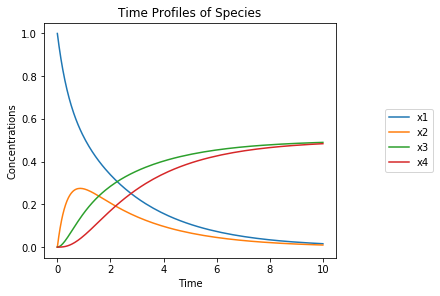

In [11]:
fig_4_3 = plt.figure(constrained_layout=True, figsize=(6, 4))
gs = fig_4_3.add_gridspec(nrows=1, ncols=1)

ax1 = fig_4_3.add_subplot(gs[0, 0])

plot_time_profile(
    conc_sol, ax=ax1, legend="right outside",
    xlabel="Time", ylabel="Concentrations",
    title=("Time Profiles of Species", {"size": "large"}));

*__Figure 4.3:__ The dynamic response of the reactions in Eq. (4.17) for \\(K_1=K_3=1\\) and \\(k_1=k_2=k_3=1\\). The graphs show the concentrations varying with time for \\(x_1(0)=1, x_2(0)=x_3(0)=x_4(0)=0\\).*

The kinetic effects of \\(x_2\\) are thus felt through both reactions 2 and 3 (i.e., the second and third column in \\(\textbf{S}\\) that are the corresponding reaction vectors), \\(\textbf{s}_2\\) and \\(\textbf{s}_3\\). These two reaction vectors are weighted by the rate constants (reciprocal of the time constants). Therefore, we expect that if \\(k_2\\) is numerically much smaller than \\(k_{-1}\\) then the dynamic coupling is 'weak.' We consider two sets of parameter values. 

* First, we simulate this system with all the rate constants being equal, Figure 4.3. All the concentrations are moving on the same time scale. For a series of reactions, the overall dynamics are expected to unfold on a time scale that is the sum of the individual time constants. Here, this sum is three, and the dynamics have relaxed after a time period of three to five times this value. 

* Next, we make the second reaction ten times slower compared to the other two by decreasing \\(k_2\\). We see that the two faster reactions come to a quasi-equilibrium state relatively quickly (relative to reaction 3), and form two conservation pools that exchange mass slowly. The sum of the rate constants for the three reactions in series is now seven, and the dynamics unfold on this time scale. 

#### 2) Stoichiometric decoupling
Reaction 3 does not influence reaction 1 at all. They are separated by the irreversible reaction 2. Thus, changes in the kinetics of reaction 3 will not influence the progress of reaction 1. This can be illustrated through simulation by changing the rate constants for reaction 3 and observing what happens to reaction 1. 

#### 3) Formation of multi-reaction pools:
We can form the following pooled variables based on the properties of the individual reversible reactions

$$\begin{align} &p_1 = x_1 - x_2/K_1\ && disequilibrium\ quantity\ for\ reaction\ 1 \\ &p_2 = x_1 + x_2    \ && conservation\ quantity\ for\ reaction\ 1 \\ &p_3 = x_3 - x_4/K_3\ && disequilibrium\ quantity\ for\ reaction\ 3 \\ &p_4 = x_3 + x_4    \ && conservation\ quantity\ for\ reaction\ 3\end{align} \tag{4.34}$$

A representation of the dynamics of this reaction system can be obtained by plotting these pools as a function of time; Figure 4.4a. To prepare this plot, we use the pooling matrix 

$$\begin{equation} \textbf{P} = \begin{pmatrix} {1} & {-1/K_1} & {0} & {0} \\ {1} & {1} & {0} & {0} \\ {0} & {0} & {1} & {-1/K_3}  \\ {0} & {0} & {1} & {1} \\ \end{pmatrix} \tag{4.35} \end{equation}$$
                              
to post-process the output. However, we note that the conservation quantities associated with the individual reactions are no longer time-invariant. 

The rank of \\(\textbf{S}\\) is 3 and its one-dimensional left null space is spanned by (1,1,1,1); thus the conservation quantity is \\(x_1 + x_2 + x_3 + x_4\\). Therefore an alternative pooling matrix may be formulated as 

$$\begin{equation} \textbf{P} = \begin{pmatrix} {1} & {-1/K_1}  & {0} & {0} \\ {0} & {1} & {0} & {0} \\ {0} & {0} & {1} & {-1/K_3} \\ {1} & {1} & {1} & {1} \\ \end{pmatrix} \tag{4.36} \end{equation}$$
                              
where we use \\(x_2\\) as the coupling variable and the overall conservation pool instead of the conservation pools associated with the individual reactions. The two conservation pools are combined into one overall mass conservation pool. 

We can now derive the dynamic mass balances on the pools as 

$$\begin{align} \frac{d\textbf{p}}{dt} = \textbf{PSv} &= \begin{pmatrix} {-(k_1 + k_{-1})(x_1 - x_2/K_1) +\frac{k_2}{K_1}x_2} \\ {k_1(x_1 - x_2/K_1) - k_2x_2} \\ {-(k_3 + k_{-3})(x_3 - x_4/K_3) +k_2x_2} \\ {0}\end{pmatrix}  \\ &= \begin{pmatrix} {-(k_1 + k_{-1})p_1 +\frac{k_2}{K_1}x_2} \\ {k_1p_1 - k_2p_2} \\ {-(k_3 + k_{-3})p_3 +k_2p_2} \\{0}\end{pmatrix} \\ &= \begin{pmatrix} {-(k_1 + k_{-1})} \\ {k_1}  \\ {0} \\ {0} \end{pmatrix}p_1 + \begin{pmatrix} {\frac{k_2}{K_1}} \\ {-k_2} \\ {k_2} \\ {0} \end{pmatrix}p_2 + \begin{pmatrix} {0} \\ {0} \\ {-(k_3 + k_{-3})} \\ {0} \end{pmatrix}p_3 \end{align} \tag{4.37}$$
                              
This equation shows that \\(p_1\\) and \\(p_3\\) create fast motion compared to \\(p_2\\) given the relative numerical values of the rate constants; \\(p_2\\) creates a slow drift in this system for the numerical values used in Figure 4.4b. 

##### Define pools

In [12]:
# Define pools
reg_pools = ['x1 - x2 / Keq_v1', 'x1 + x2', 
             'x3 - x4 / Keq_v3', 'x3 + x4']

alt_pools = ['x1 - x2 / Keq_v1', 'x2', 
             'x3 - x4 / Keq_v3', 'x1 + x2 + x3 + x4']

for prefix, pools in zip(["p", "alt_p"], [reg_pools, alt_pools]):
    for i, equation_str in enumerate(pools):
        pool_id = prefix + str(i + 1)
        conc_sol.make_solution_from_equation(
            pool_id, equation=equation_str,
            parameters={v1.Keq_str: v1.Keq, v3.Keq_str: v3.Keq},
            update=True)

##### Visualize solutions

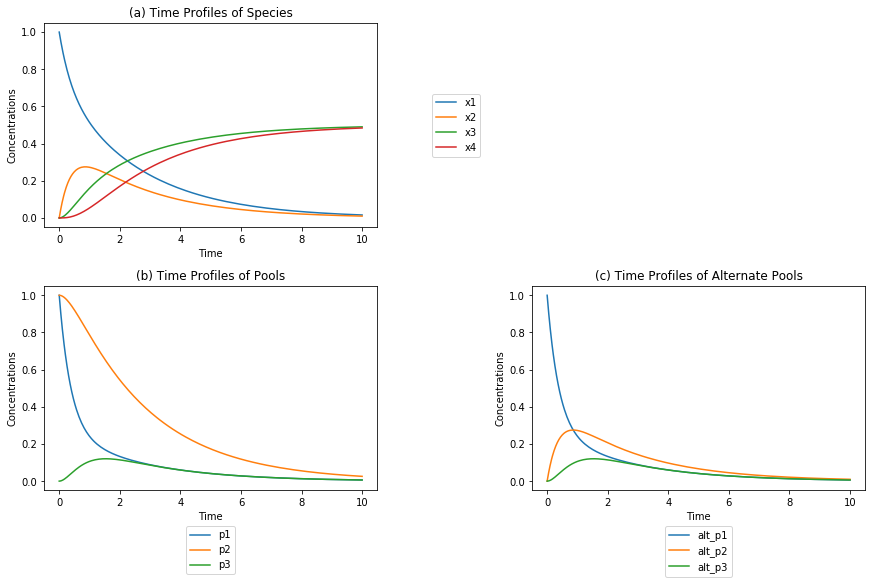

In [13]:
fig_4_4 = plt.figure(constrained_layout=True, figsize=(12, 8))
gs = fig_4_4.add_gridspec(nrows=2, ncols=2)

ax1 = fig_4_4.add_subplot(gs[0, 0])
ax2 = fig_4_4.add_subplot(gs[1, 0])
ax3 = fig_4_4.add_subplot(gs[1, 1])

plot_time_profile(
    conc_sol, ax=ax1, observable=model.metabolites,
    legend="right outside", xlabel="Time", ylabel="Concentrations",
    title=("(a) Time Profiles of Species", {"size": "large"}));

plot_time_profile(
    conc_sol, observable=["p1", "p2", "p3"], ax=ax2,
    legend="lower outside", xlabel="Time", ylabel="Concentrations",
    title=("(b) Time Profiles of Pools", {"size": "large"}));

plot_time_profile(
    conc_sol, observable=["alt_p1", "alt_p2", "alt_p3"], ax=ax3,
    legend="lower outside", xlabel="Time", ylabel="Concentrations",
    title=("(c) Time Profiles of Alternate Pools",  {"size": "large"}));

*__Figure 4.4:__ (a) The time profiles (b) The conservation pools \\(p_2 = x_1 + x_2\\) and \\(p_4 = x_3 + x_4\\) and the disequilibrium pools \\(p_1 = x_1 - x_2/K_1\\) and \\(p_3 = x_3 - x_4/K_3\\) for the individual reactions. The disequilibrium pools move quickly towards a quasi-equilibrium state, while the conservation pools move more slowly. These pools are defined in Eq (4.35). (c) The dynamic response with alternative pools; \\(p_2 = x_2\\), and \\(p_4 = x_1 + x_2 + x_3 + x_4\\). These pools are defined in Eq (4.36).*

## 4.5 Connected Reversible Bi-linear Reactions
An important case of connected bi-linear reactions is represented by the reaction mechanism 

$$\begin{equation} x_1 + x_2 \underset{v_{-1}}{\stackrel{v_1}{\rightleftharpoons}} x_3 \underset{v_{-2}}{\stackrel{v_2}{\rightleftharpoons}} x_4 + x_5 \tag{4.38} \end{equation}$$

This reaction network is similar to reaction mechanisms for enzymes, and thus leads us into the treatment of enzyme kinetics (Chapter 5). The elementary reaction rates are: 

$$\begin{equation} v_1 = k_1x_1x_2, \ \  v_{-1} = k_{-1}x_3 \ \ v_2 = k_2x_3, \text{and} \ \ v_{-2} = k_{-2}x_4x_5 \tag{4.39} \end{equation}$$

and the equilibrium constants are \\(K_1 = k_1/k_{-1}\\) and \\(K_2 = k_2/k_{-2}\\). There are two disequilibrium quantities. 

$$\begin{equation} p_1 = x_1x_2 - x_3 / K_1 \tag{4.40} \end{equation}$$
$$\begin{equation} p_2 = x_3 - x_4x_5 / K_2 \tag{4.41} \end{equation}$$

We now explore the same features of this coupled system of bi-linear reactions as we did for the single reversible bi-linear reaction. 

#### 1) Conservation quantities
The (5x4) stoichiometric matrix 

$$\begin{equation} \textbf{S} = \begin{pmatrix} {-1} & {1} & {0} & {0} \\ {-1} & {1} & {0} & {0} \\ {1} & {-1} & {-1} & {1} \\ {0} & {0} & {1} & {-1} \\ {0} & {0} & {1} & {-1} \\ \end{pmatrix} \tag{4.42} \end{equation}$$

has a rank of 2 and thus there are three conservation variables and two independent dynamic variables. 

The conservation quantities are not unique and which one we will use depends on the reaction chemistry that is being studied. An example is 

$$\begin{equation} AB + C \underset{v_{-1}}{\stackrel{v_1}{\rightleftharpoons}} ABC \underset{v_{-2}}{\stackrel{v_2}{\rightleftharpoons}} A + BC \tag{4.43} \end{equation}$$

in which case the three independent conservation quantities would be: 

$$\begin{equation} \text{Conservation of A}:\ p_3 =  x_1 + x_3 + x_4 \\ \text{Conservation of B}:\ p_4 =  x_1 + x_3 + x_5 \\ \text{Conservation of C}:\ p_5 =  x_2 + x_3 + x_5  \tag{4.44} \end{equation}$$ 

These are convex quantities as all the coefficients are non-negative (the concentrations are \\(x_i>0\\)). The individual bi-linear reactions have two each, but once coupled, the number of conservation quantities drops by one. 

#### 2) The equilibrium state
The computation of the equilibrium state involves setting the net fluxes to zero and combining those equations with the conservation quantities to get a set of independent equations. For convenience of illustration, we pick \\(K_1 = K_2 = 1\\) and the equilibrium equations become 

$$\begin{equation} x_{1, eq}x_{2, eq} = x_{3, eq} = x_{4, eq}x_{5, eq} \tag{4.45} \end{equation}$$

and if we pick \\(p_3 = p_4 = p_5 = 3\\) then the solution for the equilibrium state is simple: \\(x_{1, eq}x_{2, eq} = x_{3, eq} = x_{4, eq}x_{5, eq} = 1\\). These equations can also be solved for arbitrary parameter values. 

#### 3) Linearization and deviation variables
By linearizing the differential equations around the steady state we obtain 

$$\begin{align} \frac{dx_1'}{dt} &= \frac{dx_2'}{dt} = -(k_1x_{1,eq})x_2' -(k_1x_{2,eq})x_1' + k_{-1}x_3' \\ \frac{dx_3'}{dt} &= (k_1x_{2,eq})x_1' + (k_1x_{1,eq})x_2' - (k_{-1} + k_2)x_3' + (k_{-2}x_{5,eq})x_4'+ (k_{-2}x_{4,eq})x_5'\\ \frac{dx_4'}{dt} &= \frac{dx_5'}{dt} = k_{2}x_3' - (k_{-2}x_{5,eq})x_4' -(k_{-2}x_{4,eq})x_5' \end{align} \tag{4.46} $$

where \\(x_i' = x_i - x_{i, eq}\\) represent the concentration deviation around equilibrium, \\(i\\) =1,2,3,4 and 5.

#### 4) The disequilibrium and conservation quantities
Similar to the reversible bi-linear reaction, we obtain two pools that represent the disequilibrium driving forces of the two reactions, 

$$\begin{align} p_1 &= x_1x_2 - x_3 / K_1 \approx (x_{2, eq})x_1' + (x_{1, eq})x_2' - (1/K_1)x_3' = p_1'\\ p_2 &= x_3 - x_4x_5 / K_2 \approx x_3' - (x_{5, eq}/K_2)x_4' - (x_{4, eq}/K_2)x_5' = p_2' \end{align} \tag{4.47}$$

and the three pools that represent conservative quantities do not change: 

$$\begin{align} p_3 &=  x_1 + x_3 + x_4 \\ p_4 &=  x_1 + x_3 + x_5 \\ p_5 &=  x_2 + x_3 + x_5 \end{align} \tag{4.48} $$ 

We thus can define the pooling matrix as: 

$$\begin{align}  \textbf{P} &= \begin{pmatrix} {x_{2, eq}} & {x_{1, eq}} & {1/K_1} & {0} & {0} \\ {0} & {0} & {1} & {-x_{5, eq}/K_2} & {-x_{4, eq}/K_2} \\ {1} & {0} & {1} & {1} & {0} \\ {1} & {0} & {1} & {0} & {1} \\ {0} & {1} & {1} & {0} & {1} \\ \end{pmatrix} \\ &= \begin{pmatrix}  {1} & {1} & {-1} & {0} & {0} \\ {0} & {0} & {1} & {-1} & {-1} \\ {1} & {0} & {1} & {1} & {0} \\ {1} & {0} & {1} & {0} & {1} \\ {0} & {1} & {1} & {0} & {1} \\ \end{pmatrix} \end{align} \tag{4.49}$$

for the particular equilibrium constants and concentrations values given above. 

The differential equations for the pools are then formed by (and at this stage we remove the conservation pools as they are always constant): 

$$\begin{equation} \frac{d\textbf{p'}}{dt} = \textbf{PSv(x)} \ \text{where} \ \textbf{v(x)} \approx \begin{pmatrix} {k_1p_1'} \\ {k_2p_2'} \\ \end{pmatrix} = \begin{pmatrix} {k_1} & {0} \\ {0} & {k_2} \\ \end{pmatrix} \begin{pmatrix} {p_1'} \\ {p_2'} \\ \end{pmatrix} \tag{4.50} \end{equation}$$

which gives 

$$\begin{equation} \frac{d\textbf{p'}}{dt} = \begin{pmatrix} {-(x_{2, eq} + x_{1, eq} + 1/K_1)} \\ {1} \\ \end{pmatrix}k_1p_1' + \begin{pmatrix} {1/K_1} \\ {-(1 + (x_{5, eq} + x_{4, eq})/K_2} \\ \end{pmatrix}k_2p_2' \tag{4.51} \end{equation}$$

#### 5) Numerical simulation 
These equations can be simulated once parameter values and initial conditions are specified. In order to illustrate the dynamic behavior in terms of the pools, we consider the particular situation where \\(K_1 = K_2 = x_{1, eq} = x_{2, eq} = x_{3, eq} = x_{4, eq} = x_{5, eq} = 1\\), see Figure 4.5. 

##### Create MassModel

In [14]:
# Create MassModel
model = MassModel('Connected_BiLinear_Reversible')
# Generate the MassMetabolites 
x1 = MassMetabolite("x1")
x2 = MassMetabolite("x2")
x3 = MassMetabolite("x3")
x4 = MassMetabolite("x4")
x5 = MassMetabolite("x5")
# Generate the MassReactions 
v1 = MassReaction("v1")
v2 = MassReaction("v2")
# Add metabolites to the reaction, add reaction to the model
v1.add_metabolites({x1: -1, x2: -1, x3: 1})
v2.add_metabolites({x3: -1, x4: 1, x5: 1})
model.add_reactions([v1, v2])
# Set parameters and initial conditions
v1.kf = 1
v1.kr = 1
v2.kf = 1
v2.kr = 1
model.update_initial_conditions({x1: 3, x2: 3, x3: 0, x4: 0, x5: 0})

# Utilize type 2 rate law for kf and kr parameters defined
model.get_rate_expressions(rate_type=2, update_reactions=True)
model

Name,Connected_BiLinear_Reversible
Memory address,0x013042dd68
Stoichiometric Matrix,5x2
Matrix Rank,2
Number of metabolites,5
Initial conditions defined,5/5
Number of reactions,2
Number of genes,0
Number of enzyme modules,0
Number of groups,0
Objective expression,0


##### Simulate MassModel

In [15]:
t0 = 0
tf = 10
sim = Simulation(model, verbose=True, variable_step_size=True)
conc_sol, flux_sol = sim.simulate(model, time=(t0, tf), verbose=True)

# Define pools
pools = ['x1*x2 - x3 / Keq_v1', 'x3 - x4*x5 / Keq_v2', 
         'x1 + x3 + x4', 'x1 + x3 + x5', 'x2 + x3 + x4']

for i, equation_str in enumerate(pools):
    pool_id = "p" + str(i + 1)
    conc_sol.make_solution_from_equation(
        pool_id, equation=equation_str, 
        parameters={v1.Keq_str: v1.kf/v1.kr,
                    v2.Keq_str: v2.kf/v2.kr}, update=True)

Successfully loaded MassModel 'Connected_BiLinear_Reversible' into RoadRunner.
Getting time points
Setting output selections
Setting simulation values for 'Connected_BiLinear_Reversible'
Simulating 'Connected_BiLinear_Reversible'
Simulation for 'Connected_BiLinear_Reversible' successful
Adding 'Connected_BiLinear_Reversible' simulation solutions to output
Updating stored solutions


##### Visualize solutions

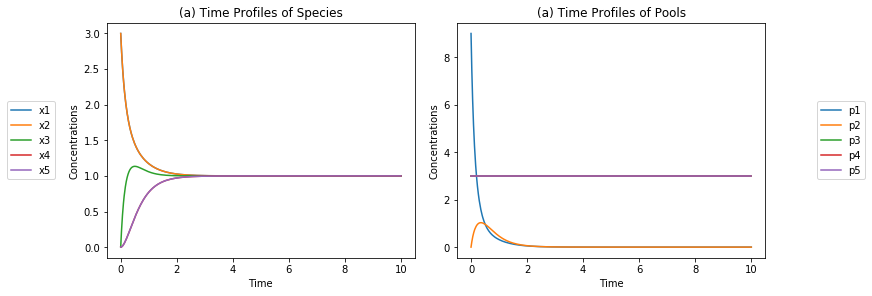

In [16]:
fig_4_5 = plt.figure(constrained_layout=True, figsize=(12, 4))
gs = fig_4_5.add_gridspec(nrows=1, ncols=2)

ax1 = fig_4_5.add_subplot(gs[0, 0])
ax2 = fig_4_5.add_subplot(gs[0, 1])

plot_time_profile(
    conc_sol, observable=model.metabolites, ax=ax1, legend="left outside",
    xlabel="Time", ylabel="Concentrations",
    title=("(a) Time Profiles of Species",  {"size": "large"}));

plot_time_profile(
    conc_sol, ax=ax2, observable=["p1", "p2", "p3", "p4", "p5"],
    legend="right outside",
    xlabel="Time", ylabel="Concentrations",
    title=("(a) Time Profiles of Pools",  {"size": "large"}));

*__Figure 4.5:__ The concentration time profiles for the reaction system \\(x_1 + x_2 \rightleftharpoons x_3 \rightleftharpoons x_4 + x_5\\) for \\(k_1 = k_{-1} = k_2 = k_{-2} = 1\\)
and \\(x_1(0)=3, x_2(0)=3, x_3(0)=0, x_4(0)=0, x_5(0)=0\\) (a) The concentrations as a function of time. (b) The pools as a function of time.*

In this situation, the dynamic equation for the linearized pools becomes 

$$\begin{equation} \frac{d\textbf{p'}}{dt} = \begin{pmatrix} {-3} \\ {1} \\ \end{pmatrix}k_1p_1' + \begin{pmatrix} {1} \\ {-3} \\ \end{pmatrix}k_2p_2' \tag{4.52} \end{equation}$$

We can solve this equation and present the results with a dynamic phase portrait, Figure 4.6. The dynamic behavior of the non-equilibrium pools is shown for a range of parameters. We make three observations here. 

1. Figure 4.6 shows that the dynamics for the pools can be decomposed to consider a fast equilibration of the two disequilibrium pools followed by the slow decay of the slower disequilibrium pool (Change values for \\(k_1\\) and \\(k_2\\) to visualize). 

2. When reaction 1 is 10 times faster than reaction 2, then initial motion is along the vector \\((-3,1)^T\\), and when reaction 1 is 10 times slower than reaction 2, then initial motion is along the vector \\((1,-3)^T\\), 

3. The linearized pools move in a similar fashion to the bi-linear disequilibrium pools, see Figure 4.6. The bi-linear and linear simulation do not change that much even though \\(x_1\\), \\(x_2\\), \\(x_4\\), \\(x_5\\) are 25% from their equilibrium value, and \\(x_3\\) is 50% away from equilibrium. 

In [17]:
# Set new initial conditions
model.update_initial_conditions({x1: 0.75, x2: 0.75, x3: 1.5, 
                                 x4: 0.75, x5: 0.75})
sim.update_model_simulation_values(model)
conc_sol, flux_sol = sim.simulate(model, time=(t0, tf))

for i, equation_str in enumerate(pools):
    pool_id = "p" + str(i + 1)
    conc_sol.make_solution_from_equation(
        pool_id, equation=equation_str, 
        parameters={v1.Keq_str: v1.kf/v1.kr,
                    v2.Keq_str: v2.kf/v2.kr}, update=True)

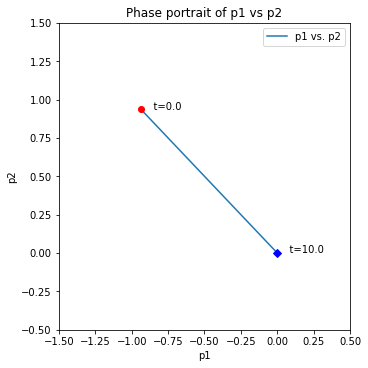

In [18]:
# Visualize solution
fig_4_5 = plt.figure(constrained_layout=True, figsize=(5, 5))
gs = fig_4_5.add_gridspec(nrows=1, ncols=1)

ax1 = fig_4_5.add_subplot(gs[0, 0])

plot_phase_portrait(
    conc_sol, x="p1", y="p2", ax=ax1, legend="best",
    xlabel="p1", ylabel="p2", xlim=(-1.5, .5), ylim=(-.5, 1.5),
    title=("Phase portrait of p1 vs p2", {"size": "large"}),
    annotate_time_points="endpoints",
    annotate_time_points_labels=True);

*__Figure 4.6:__ The dynamic response of \\(x_1 + x_2 \rightleftharpoons x_3 \rightleftharpoons x_4 + x_5\\) for \\(K_1 = K_{-1} = 1\\). The graphs show the concentrations varying with time for \\(x_3(0)=1.5, \ x_1(0) = x_2(0) = x_4(0) = x_5(0) =0.75\\) The disequilibrium pools \\(p_1 = x_1x_2 - x_3 / K_1\\) (x-axis) and \\(p_2 = x_3 - x_4x_5 / K_2\\) (y-axis) shown in a phase portrait.*

## 4.6 Summary   

* Chemical properties associated with chemical reactions are; stoichiometry thermodynamics, and kinetics. The first two are physico-chemical properties, while the third can be biologically altered through enzyme action. 


* Each net reaction can be described by pooled variables that represent a dis-equilibrium quantity and a mass conservation quantity that is associated with the reaction. 


* If a reaction is fast compared to its network environment, its disequilibrium variable can be relaxed and then described by the conservation quantity associated with the reaction. 


* Linearizing bi-linear rate laws does not create much error for small changes around the reference state. 


* Removing a time scale from a model corresponds to reducing the dynamic dimension of the transient response by one. 


* As the number of reactions grow, the number of conservation quantities may change. 


* Irreversibility of reactions does not change the number of conservation quantities for a system. 

\\(\tiny{\text{© B. Ø. Palsson 2011;} \ 
\text{This publication is in copyright.}\\ 
\text{Subject to statutory exception and to the provisions of relevant collective licensing agreements,}\\ \text{no reproduction of any part may take place without the written permission of Cambridge University Press.}}\\)